In [116]:
import numpy as np
import pandas as pd

import os
import json
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

In [2]:
training_path = '../data/training'
task_file = os.path.join(training_path, '0520fde7.json')

with open(task_file, 'r') as f:
    task = json.load(f)

print(task.keys())

dict_keys(['train', 'test'])


In [3]:
# specify colors
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

black = 0
blue = 1
red = 2
green = 3
yellow = 4
grey = 5
magenta = 6
orange = 7
light_blue = 8
maroon = 9

def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    norm = colors.Normalize(vmin=0, vmax=9)
    n_train = len(task['train'])
    fig, axs = plt.subplots(n_train+1, 2, figsize=(10, 10))
    for i in range(n_train):
        axs[i, 0].imshow(task['train'][i]['input'], cmap=cmap, norm=norm)
        axs[i, 0].axis('off')
        axs[i, 0].set_title('Train Input')
        axs[i, 1].imshow(task['train'][i]['output'], cmap=cmap, norm=norm)
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Train Output')
    axs[n_train, 0].imshow(task['test'][0]['input'], cmap=cmap, norm=norm)
    axs[n_train, 0].axis('off')
    axs[n_train, 0].set_title('Test Input')
    axs[n_train, 1].imshow(task['test'][0]['output'], cmap=cmap, norm=norm)
    axs[n_train, 1].axis('off')
    axs[n_train, 1].set_title('Test Output')
    plt.tight_layout()
    plt.show()
    
def plot_grid(grid):
    """
    Plots a single grid
    """
    norm = colors.Normalize(vmin=0, vmax=9)
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap=cmap, norm=norm)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def plot_grids(grids):
    """
    Plots a list of grids
    """
    n_grids = len(grids)
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, n_grids, figsize=(10, 10))
    for i in range(n_grids):
        axs[i].imshow(grids[i], cmap=cmap, norm=norm)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

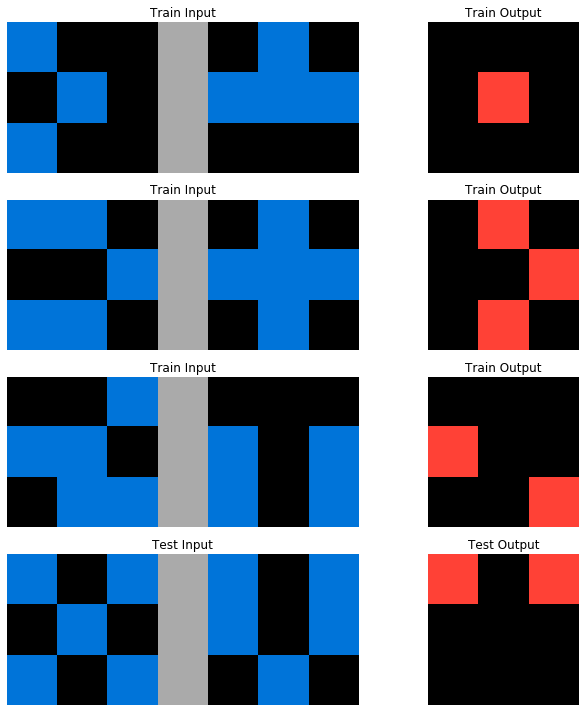

In [4]:
plot_task(task)

In [5]:
train = task['train']

def extract_io_pairs(task):
    train = task['train']
    test = task['test']
    n_train = len(train)
    n_test = len(test)
    
    train_inputs = np.array([train[i]['input'] for i in range(n_train)])
    train_outputs = np.array([train[i]['output'] for i in range(n_train)])
    test_inputs = np.array([test[i]['input'] for i in range(n_test)])
    test_outputs = np.array([test[i]['output'] for i in range(n_test)])
    
    return train_inputs, train_outputs, test_inputs, test_outputs
    
train_inputs, train_outputs, test_inputs, test_outputs = extract_io_pairs(task)

In [71]:
def change_color_grids(grids, input_color, output_color):
    """Changes the color of a set of grids"""
    new_grids = grids.copy()
    for grid in new_grids:
        grid[grid == input_color] = output_color
    return new_grids

In [7]:
# primitives to find dividers
# TODO: could probably separate out the functions of detecting dividers and parsing out objects
def detect_divider(grid, divider_color, divider_type):
    """Function that returns a set of indices for a given divider type"""
    dividers = []
    n_rows = grid.shape[0]
    n_cols = grid.shape[1]
    if divider_type == "vertical":
        for i in range(n_cols):
            if (grid[:, i] == divider_color).all():
                dividers.append(i)
    elif divider_type == "horizontal":
        for i in range(n_rows):
            if (grid[i, :] == divider_color).all():
                dividers.append(i)
            
    return dividers

def vertical_divider_split(grid, divider_color):
    """
    Looks for vertical dividers in a grid and returns a list
    with separate objects in an array. Assumes the color of the divider
    is known
    """
    objects = []
    dividers = detect_divider(grid, divider_color, divider_type="vertical")
    
    curr_idx = 0
    for divider in dividers:
        objects.append(grid[:, curr_idx:divider])  # append each object
        curr_idx = divider + 1
    objects.append(grid[:, curr_idx:])  # append last object
    
    return objects

def horizontal_divider_split(grid, divider_color):
    """
    Looks for horizontal dividers in a grid and returns a list
    with separate objects in an array. Assumes the color of the divider
    is known
    """
    objects = []
    dividers = detect_divider(grid, divider_color, divider_type="horizontal")
    
    curr_idx = 0
    for divider in dividers:
        objects.append(grid[curr_idx:divider, :]) # append each object
        curr_idx = divider + 1
    objects.append(grid[curr_idx:, :])  # append last object
    
    return objects

In [8]:
# logical operations
def logical_and(grids, foreground, background=0):
    # performs a logical and operation between two grids
    new_grid = np.zeros_like(grids[0])
    logical_mask = np.logical_and(grids[0], grids[1])
    new_grid[logical_mask] = foreground
    new_grid[np.invert(logical_mask)] = background
    return new_grid

def logical_or(grids, foreground, background=0):
    # performs a logical and operation between two grids
    new_grid = np.zeros_like(grids[0])
    logical_mask = np.logical_or(grids[0], grids[1])
    new_grid[logical_mask] = foreground
    new_grid[np.invert(logical_mask)] = background
    return new_grid

def logical_xor(grids, foreground, background=0):
    # performs a logical and operation between two grids
    new_grid = np.zeros_like(grids[0])
    logical_mask = np.logical_xor(grids[0], grids[1])
    new_grid[logical_mask] = foreground
    new_grid[np.invert(logical_mask)] = background
    return new_grid

def logical_not(grid, foreground, background=0):
    # performs a logical and operation between two grids
    new_grid = np.zeros_like(grid)
    logical_mask = np.logical_not(grid)
    new_grid[logical_mask] = foreground
    new_grid[np.invert(logical_mask)] = background
    return new_grid

In [9]:
# detect foreground and background colors (using heuristics)
def detect_background_color(input_grids, output_grids):
    # check for 
    # TODO: also consider returning a probability distribution?
    return black

def detect_foreground_color(input_grids, output_grids):
    return blue

In [10]:
def scale(grid, size):
    """Scales a grid by the amount specified in size"""
    n_rows = grid.shape[0]
    n_cols = grid.shape[1]
    new_grid = np.zeros((n_rows*size, n_cols*size))
    for i in range(n_rows):
        for j in range(n_cols):
            new_grid[(i*size):((i+1)*size), (j*size):(j+1)*size] = grid[i, j]
    return new_grid

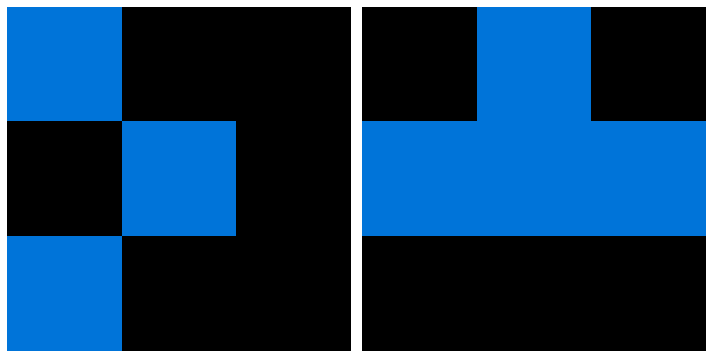

(9, 9)


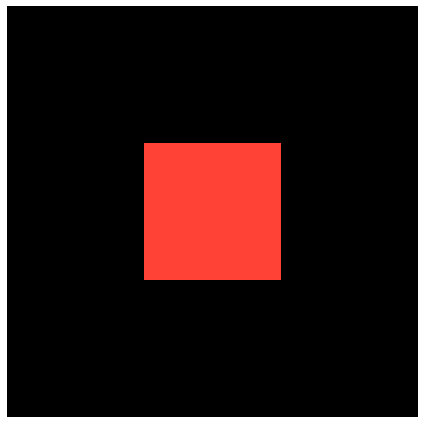

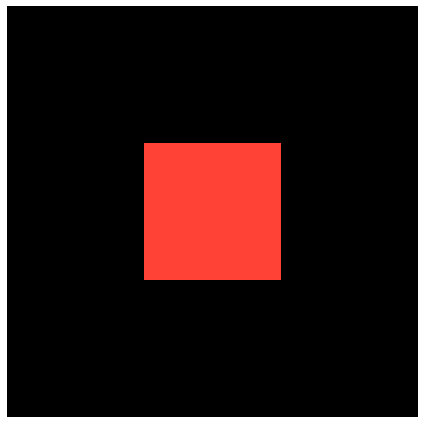

In [11]:
# example of detecting objects based on divider and then applying a logical operation, and a change color operation
objects = vertical_divider_split(train_inputs[0], divider_color=grey)
plot_grids(objects)
predicted_output = logical_and(objects, foreground=red)
print(scale(predicted_output, 3).shape)
plot_grid(predicted_output)
plot_grid(train_outputs[0])

In [46]:
# solving grid f76d97a5.json with change_color
task_file = os.path.join(training_path, 'f76d97a5.json')

with open(task_file, 'r') as f:
    task = json.load(f)
    
train_inputs, train_outputs, test_inputs, test_outputs = extract_io_pairs(task)

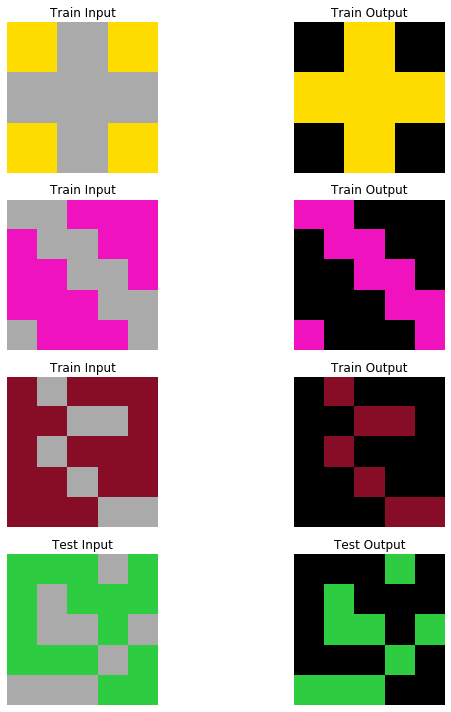

In [26]:
plot_task(task)

In [77]:
def change_color(grid, input_color, output_color):
    """Changes the color of a single grid"""
    new_grid = np.asarray(grid[:])
    new_grid[new_grid == input_color] = output_color
    return new_grid

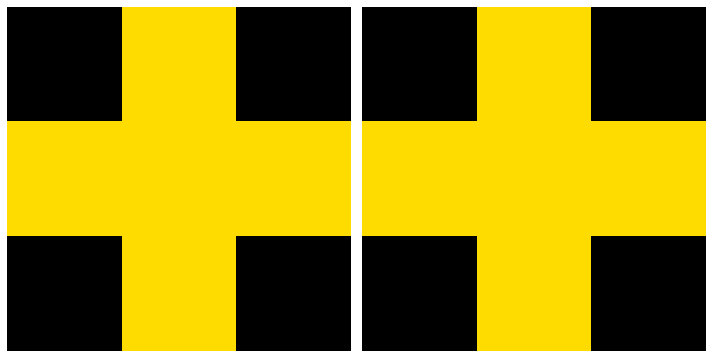

In [81]:
predicted_output = change_color(change_color(train_inputs[0],4,0),5,4)
plot_grids([predicted_output, train_outputs[0]])

In [82]:
# solving grid f5b8619d.json
task_file = os.path.join(training_path, 'f5b8619d.json')

with open(task_file, 'r') as f:
    task = json.load(f)
    
train_inputs, train_outputs, test_inputs, test_outputs = extract_io_pairs(task)

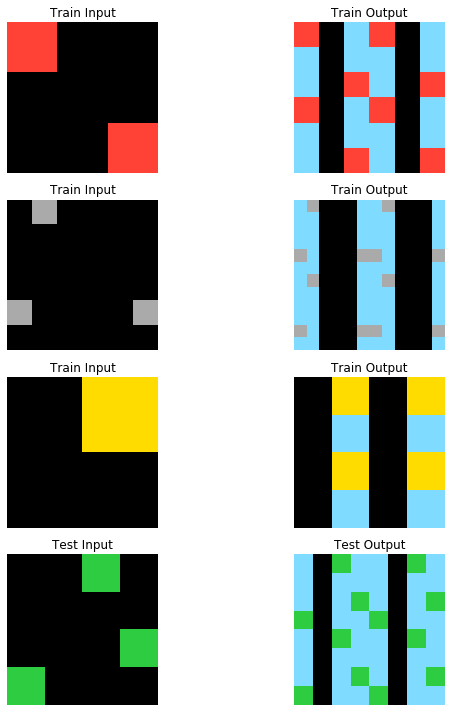

In [83]:
plot_task(task)

In [87]:
def copy_paste_full(grid, count):
    """"
    makes copies of original in both horizontal and vertical directions -- make horizontal and vertical extensions later
    """"
    grid = np.asarray(grid)
    nrows = len(grid[:,0])
    ncols = len(grid[0,:])
    new_grid = np.zeros((nrows*count,ncols*count))
    for i in np.arange(0,nrows*count)[::nrows]:
        for j in np.arange(0,ncols*count)[::ncols]:
            new_grid[i:i+nrows,j:j+ncols] = grid
    return new_grid

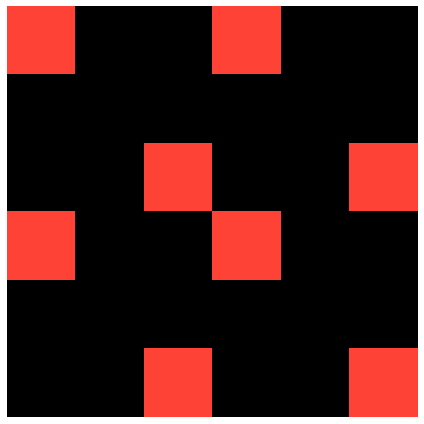

In [94]:
copied = copy_paste_full(train_inputs[0],2)
plot_grid(copied)

In [96]:
def extend_columns(grid, color):
    """
    extend any column that has a non black pixel with color argument
    """
    grid = np.asarray(grid)
    new_grid = grid[:]
    ncols = len(grid[0,:])
    for col in range(ncols):
        if np.any(grid[:,col]):
            grid[:,col][grid[:,col]==0] = color
    return grid

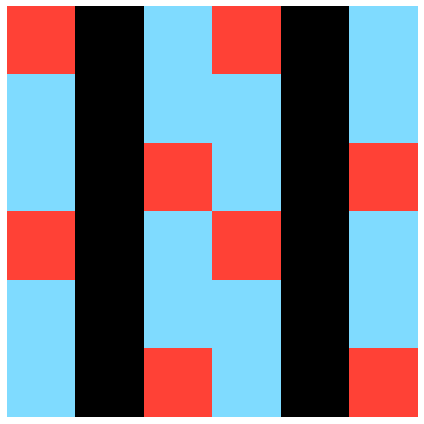

In [95]:
plot_grid(extend_columns(copied,8))

In [97]:
# solving grid f8ff0b80.json
task_file = os.path.join(training_path, 'f8ff0b80.json')

with open(task_file, 'r') as f:
    task = json.load(f)
    
train_inputs, train_outputs, test_inputs, test_outputs = extract_io_pairs(task)

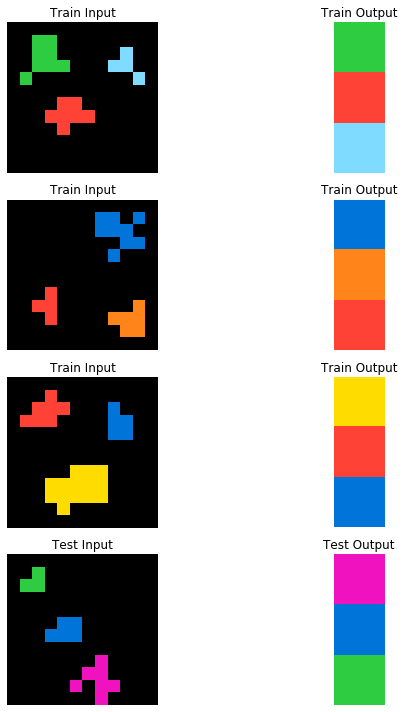

In [98]:
plot_task(task)

In [100]:
def pixel_count_by_color(grid):
    """
    returns a dictionary of color keys and count values
    """
    grid = np.asarray(grid)
    color_dict = dict.fromkeys(np.arange(0,10),0)
    nrows = len(grid[0,:])
    ncols = len(grid[:,0])
    for i in range(nrows):
        for j in range(ncols):
            if grid[i][j] != 0:
                color_dict[grid[i][j]] += 1
    return color_dict

In [115]:
def decreasing_stack(color_dictionary, length):
    """
    returns a length by 1 grid based on decreasing values in color dictionary
    """
    grid = np.zeros((length,1))
    k = Counter(color_dictionary)
    largest = k.most_common(length)
    for i in range(length):
        grid[i][0] = largest[i][0]
    return grid

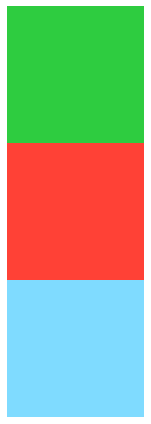

In [114]:
color_dictionary = pixel_count_by_color(train_inputs[0])
plot_grid(decreasing_stack(color_dictionary,3))

In [145]:
# solving grid f25ffba3.json
task_file = os.path.join(training_path, 'f25ffba3.json')

with open(task_file, 'r') as f:
    task = json.load(f)
    
train_inputs, train_outputs, test_inputs, test_outputs = extract_io_pairs(task)

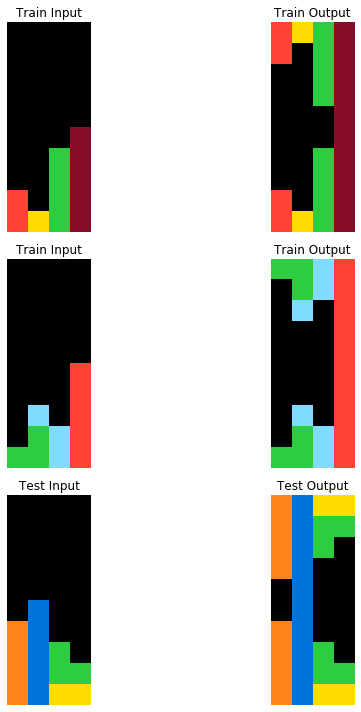

In [143]:
plot_task(task)

In [140]:
def reflect_xaxis(grid):
    """
    reflects grid across x axis, assumes even number of rows and no deletions
    """
    # why is it editing the original grid?!
    grid = np.asarray(grid)
    new_grid = grid[:]
    nrows = len(grid[:,0])
    axis = int(nrows/2)
    if np.any(grid[:axis,:]):
        new_grid[axis:,:] = np.flipud(new_grid[:axis,:])
    else:
        new_grid[:axis,:] = np.flipud(new_grid[axis:,:])
    return new_grid

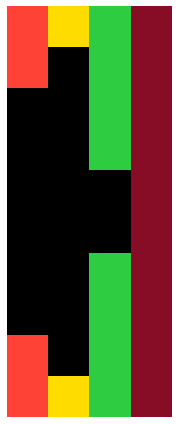

In [147]:
plot_grid(reflect_xaxis(train_inputs[0]))

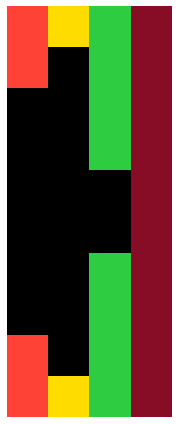

In [148]:
plot_grid(train_inputs[0])